# Dark matter shards of $\omega$ centauri
Taking the the velocities of the objects reported in https://arxiv.org/abs/1804.07050 and creating a composite velocity distribution from them

In [2]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from LabFuncs import *
from Params import *
from HaloFuncs import *
from WIMPFuncs import *
import pandas

# Set plot rc params
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#######

# v range
n = 100
v = linspace(0,850.0,n)

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
day = 67.0 
v_lab = LabFuncs.LabVelocitySimple(day)

# Load shards
df = pandas.read_csv('../Shards.csv')
print df
names = df.ID
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
pops /= sum(pops) # normalise all populations to 1


# Speed distributions
fv_Iso = SpeedDist_Isotropic(v,day) # Round halo
fv_Saus = SpeedDist_Triaxial(v,day,sig_beta) # Sausage
fv_Iso_gal = SpeedDist_Triaxial(v,day,array([1.0,1.0,1.0])*233.0/sqrt(2.0),v_shift=v_lab) # Galactic frame Halo
fv_Saus_gal = SpeedDist_Triaxial(v,day,sig_beta,v_shift=v_lab) # Galactic frame Sausage

fv = zeros(shape=(nshards,n))
fv_gal = zeros(shape=(nshards,n))
for i in range(0,nshards):
    v_s = velocities[i,:]
    sig_s = dispersions[i,:]
    fv[i,:] = pops[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s)
    fv_gal[i,:] = pops[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=(v_s+v_lab))
    sigr = sig_s[0]
    sigphi = sig_s[1]
    sigz = sig_s[2]
    beta = 1.0-(sigr**2.0+sigz**2.0)/(2*sigr**2.0)

         ID       vx       vy       vz     sigx    sigy     sigz  population
0        S1   -8.600 -286.700  -67.900  115.300  49.900   60.000        34.0
1       Rg1   54.100 -393.800   68.300  147.200  45.700  149.400        20.0
2       Rg2   47.800 -254.600   71.800  110.200  27.800  172.100        20.0
3       Rg3   28.000 -275.100   18.000  186.000  62.700  136.500        16.0
4       Rg4  177.600 -287.900  117.900  114.600  46.000  162.700        13.0
5       Rg5  -10.000  -82.300   -0.600   83.200  21.200  162.700        29.0
6       Rg6  -11.900 -222.100   88.000  187.600  44.000  134.900        30.0
7       Rg7  -92.300 -160.200  -33.400  274.600  66.500  178.100        14.0
8        S2  -11.200  159.600 -166.500   65.600  21.900  151.700        73.0
9        C2 -242.400  109.900  180.700  229.200  35.900  236.100        22.0
10    Cand8    8.200  192.000  -25.000  124.000  40.200  186.600        49.0
11    Cand9   48.400  164.500 -171.100  139.600  24.200  172.000        44.0

## Speed distributions
Plot speed distributions of each shard individually and the population weighted composite distribution

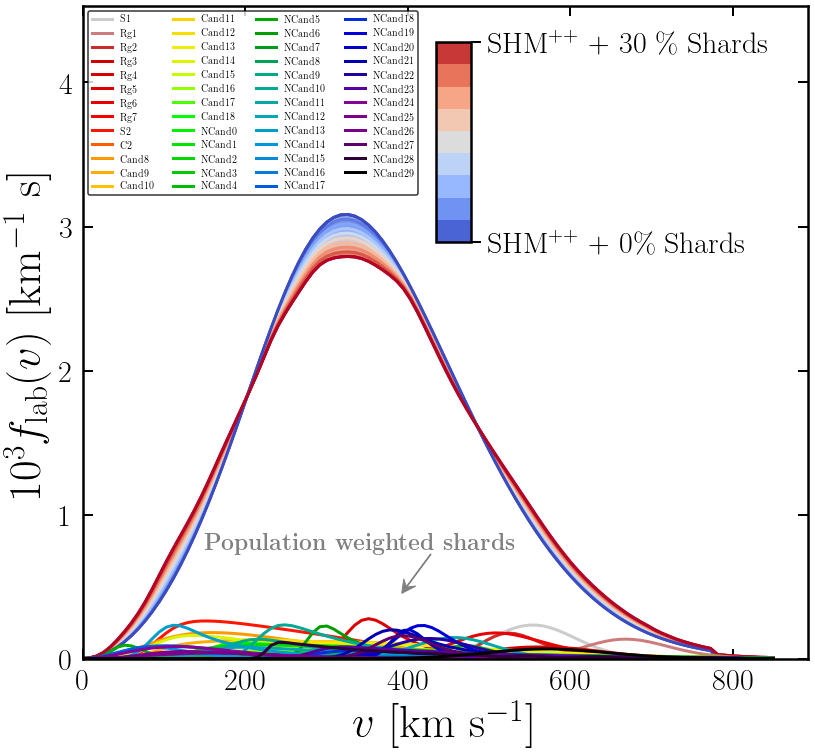

In [10]:
# Figure setup
fig = plt.figure(figsize=(13,12))
ax = fig.add_subplot(111)
pltname = 'Shards_fv'

eta_saus = 0.25
fv0 = (1-eta_saus)*fv_Iso + eta_saus*fv_Saus

n_xi = 10
xi_vals = linspace(0,0.3,n_xi)
col = (cm.coolwarm(linspace(0,1,n_xi)))
cmap = cm.coolwarm
y2 = 1e3*(xi_vals[-1]*sum(fv,0)+(1.0-xi_vals[-1])*fv0)
for i in range(0,n_xi):
    plt.fill_between(v,1e3*(xi_vals[i]*sum(fv,0)+(1.0-xi_vals[i])*fv0),y2=y2,color=col[i,:],alpha=0.5)
    plt.plot(v,1e3*(xi_vals[i]*sum(fv,0)+(1.0-xi_vals[i])*fv0),'-',color=col[i,:],linewidth=3)
    
cbar_max = r'SHM$^{++}$ + 30 \% Shards'
cbar_min = r'SHM$^{++}$ + 0\% Shards'
plt.plot(v,1e3*fv0,'-',color=col[0,:],linewidth=3)
plt.plot(v,y2,'-',color=col[-1,:],linewidth=3)

# Plot individual streams
colstrs = flipud(cm.nipy_spectral(linspace(0.0,1.0,nshards)))
for i in range(0,nshards):
    #plt.fill_between(v,1e3*fv[i,:],color=colstrs[i,:],linewidth=3,alpha=0.7,label=names[i])
    plt.plot(v,1e3*fv[i,:],color=colstrs[i,:],linewidth=3,label=names[i])
leg = plt.legend(loc='upper left',fontsize=10,edgecolor='k',ncol=4)
leg.get_frame().set_linewidth(1.5)
    
# Plot fiddling
ax.set_xlim(left=0.0)
ax.set_ylim(bottom=0.0,top=max(1e3*fv_Iso)*1.6)
ax.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10,labelsize=30)
ax.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
plt.xlabel(r"$v$ [km s$^{-1}$]",fontsize=45);
plt.ylabel(r"$10^3 f_{\rm lab}(v)$ [km$^{-1}$ s]",fontsize=45);
plt.text(150,0.75,r'\bf {Population weighted shards}',fontsize=23,color='gray')
plt.arrow(0.48, 0.16, -0.04, -0.06, transform=ax.transAxes,length_includes_head=True,head_width=0.02, head_length=0.02, overhang=0.4,edgecolor='gray',facecolor='gray')

# Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-190, 330, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([cbar_min, cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)


# Save figure
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

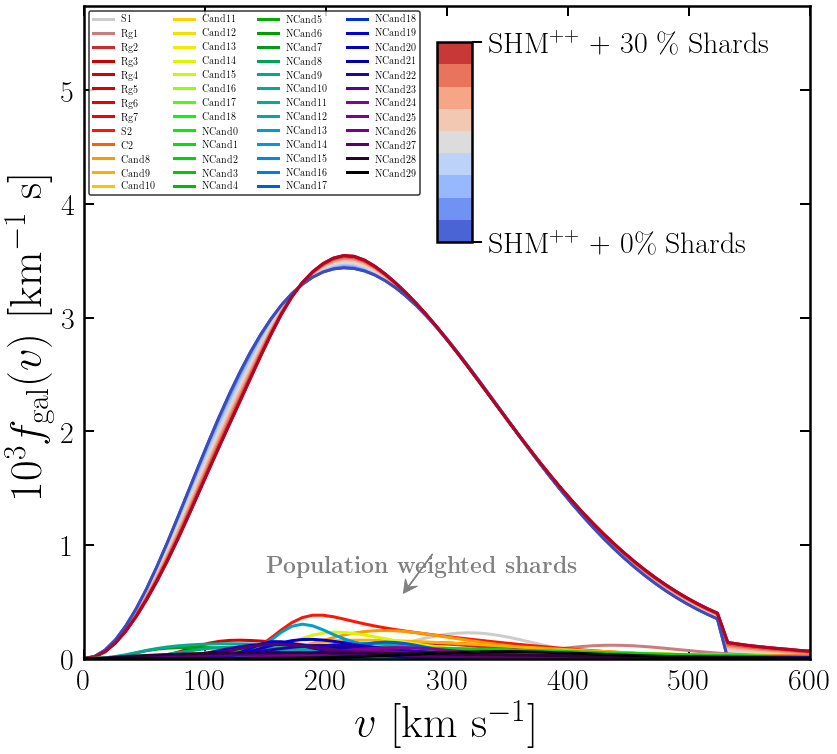

In [13]:
# Figure setup
fig = plt.figure(figsize=(13,12))
ax = fig.add_subplot(111)
pltname = 'Shards_fvgal'

eta_saus = 0.25
fv0_gal = (1-eta_saus)*fv_Iso_gal + eta_saus*fv_Saus_gal

n_xi = 10
xi_vals = linspace(0,0.3,n_xi)
col = (cm.coolwarm(linspace(0,1,n_xi)))
cmap = cm.coolwarm
y2 = 1e3*(xi_vals[-1]*sum(fv_gal,0)+(1.0-xi_vals[-1])*fv0_gal)
for i in range(0,n_xi):
    plt.fill_between(v,1e3*(xi_vals[i]*sum(fv_gal,0)+(1.0-xi_vals[i])*fv0_gal),y2=y2,color=col[i,:],alpha=0.5)
    plt.plot(v,1e3*(xi_vals[i]*sum(fv_gal,0)+(1.0-xi_vals[i])*fv0_gal),'-',color=col[i,:],linewidth=3)
    
cbar_max = r'SHM$^{++}$ + 30 \% Shards'
cbar_min = r'SHM$^{++}$ + 0\% Shards'
plt.plot(v,1e3*fv0_gal,'-',color=col[0,:],linewidth=3)
plt.plot(v,y2,'-',color=col[-1,:],linewidth=3)

# Plot individual streams
colstrs = flipud(cm.nipy_spectral(linspace(0.0,1.0,nshards)))
for i in range(0,nshards):
    #plt.fill_between(v,1e3*fv[i,:],color=colstrs[i,:],linewidth=3,alpha=0.7,label=names[i])
    plt.plot(v,1e3*fv_gal[i,:],color=colstrs[i,:],linewidth=3,label=names[i])
leg = plt.legend(loc='upper left',fontsize=10,edgecolor='k',ncol=4)
leg.get_frame().set_linewidth(1.5)
    
# Plot fiddling
ax.set_xlim(left=0.0,right=600.0)
ax.set_ylim(bottom=0.0,top=max(1e3*fv_Iso_gal)*1.6)
ax.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10,labelsize=30)
ax.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
plt.xlabel(r"$v$ [km s$^{-1}$]",fontsize=45);
plt.ylabel(r"$10^3 f_{\rm gal}(v)$ [km$^{-1}$ s]",fontsize=45);
plt.text(150,0.75,r'\bf {Population weighted shards}',fontsize=23,color='gray')
plt.arrow(0.48, 0.16, -0.04, -0.06, transform=ax.transAxes,length_includes_head=True,head_width=0.02, head_length=0.02, overhang=0.4,edgecolor='gray',facecolor='gray')

# Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-190, 330, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([cbar_min, cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)


# Save figure
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

## Randomised speed distributions
Fluctuate the population in each stream by 20% to see how much the composite distribution is affected

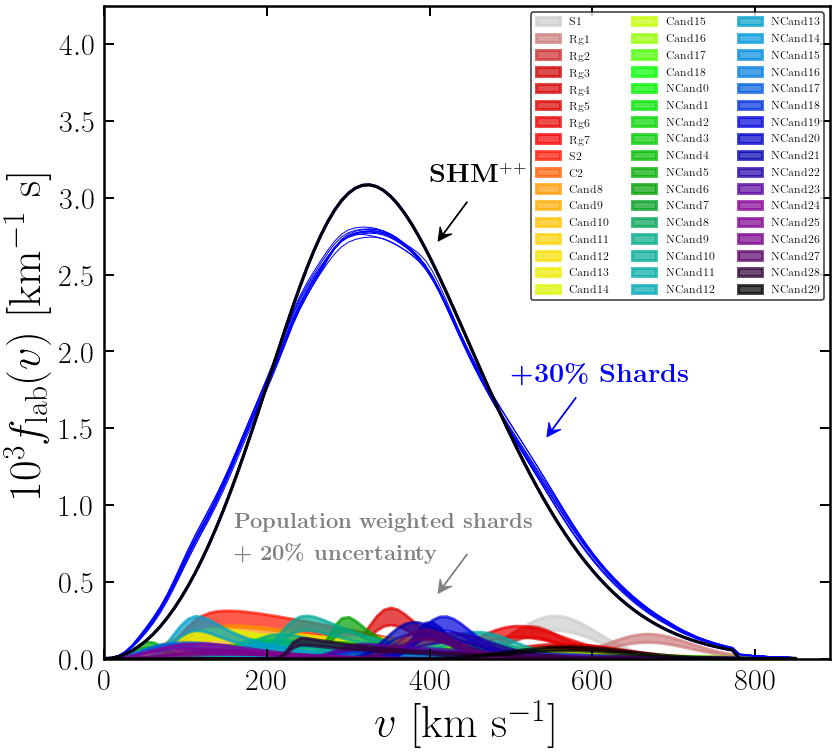

In [19]:
# Figure setup
from random import gauss
fig = plt.figure(figsize=(13,12))
ax = fig.add_subplot(111)
pltname = 'Shards_fv_random'

fv0 = (1-0.25)*fv_Iso + 0.25*fv_Saus

pop_sig = 0.2
xi_shards = 0.3
n_ex = 10
col = flipud(cm.jet(linspace(0,1,n_ex)))
for i in range(0,n_ex):
    fv_tot = zeros(shape=n)
    for j in range(0,nshards):
        npop = pops[j]*sum(df.population)
        xi_rand = gauss(npop, pop_sig*npop)
        if xi_rand<0.0:
            xi_rand = 0.0
        fv_tot += xi_rand*fv[j,:]/pops[j]
    fv_tot /= trapz(fv_tot,v)
    plt.plot(v,1e3*(xi_shards*fv_tot+(1.0-xi_shards)*fv0),'-',color="blue",linewidth=1)
    
plt.plot(v,1e3*fv0,'-',color="blue",linewidth=3)
plt.plot(v,1e3*fv0,'k-',linewidth=3)

# Plot individual streams
for i in range(0,nshards):
    npop = pops[i]*sum(df.population)
    y1 = 1e3*fv[i,:]*(1.0+pop_sig)
    y2 = 1e3*fv[i,:]*(1.0-pop_sig)
    plt.fill_between(v,y1,y2=y2,color=colstrs[i,:],linewidth=3,alpha=0.7,label=names[i])
leg = plt.legend(loc='upper right',fontsize=12,edgecolor='k',ncol=3)
leg.get_frame().set_linewidth(1.5)
     
# Plot fiddling
ax.set_xlim(left=0.0)
ax.set_ylim(bottom=0.0,top=max(1e3*fv_Iso)*1.5)
ax.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10,labelsize=30)
ax.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
plt.xlabel(r"$v$ [km s$^{-1}$]",fontsize=45);
plt.ylabel(r"$10^3 f_{\rm lab}(v)$ [km$^{-1}$ s]",fontsize=45);

# text labels
plt.text(500,1.8,r'{\bf +30\% Shards}',fontsize=27,color='b')
plt.arrow(0.65, 0.4, -0.04, -0.06, transform=ax.transAxes,length_includes_head=True,head_width=0.02, head_length=0.02, overhang=0.4,edgecolor='b',facecolor='b')


plt.text(400,3.1,r'{\bf SHM}$^{++}$',fontsize=27,color='k')
plt.arrow(0.5, 0.7, -0.04, -0.06, transform=ax.transAxes,length_includes_head=True,head_width=0.02, head_length=0.02, overhang=0.4,edgecolor='k',facecolor='k')

plt.text(160,0.85,r'\bf {Population weighted shards}',fontsize=22,color='gray')
plt.text(160,0.65,r'\bf + 20\% uncertainty',fontsize=22,color='gray')
plt.arrow(0.5, 0.16, -0.04, -0.06, transform=ax.transAxes,length_includes_head=True,head_width=0.02, head_length=0.02, overhang=0.4,edgecolor='gray',facecolor='gray')



# Save figure
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

# 2D velocity distribution
Display velocity distribution integrated over $v_z$

In [20]:
v_esc = 528.0
v_lab = array([11.1,220+12.24,7.25])
nn = 500
ni = 1000
fv2_Iso = zeros(shape=(nn,nn))
fv2_Saus = zeros(shape=(nn,nn))
vr = linspace(-600,600,nn)
vth = linspace(-800,200,nn)
v = zeros(shape=(ni,3))
vmax = v_esc + sqrt(sum(v_lab**2.0))

for i in range(0,nn):
    for j in range(0,nn):
        vzmax = vmax**2.0-vr[i]**2.0-vth[j]**2.0
        if vzmax>0.0:
            vzmax = sqrt(vzmax)
            vz = linspace(-vzmax,vzmax,ni)
            v[:,0] = vr[i]
            v[:,1] = vth[j]
            v[:,2] = vz
            fv2_Iso[i,j] = trapz(VelocityDist_Isotropic(v,day),vz)
            fv2_Saus[i,j] = trapz(VelocityDist_Triaxial(v,day,sig_beta),vz)
            
fv2_Shards = zeros(shape=(nn,nn,nshards))
for k in range(0,nshards):
    v_s = velocities[k,:]
    sig_s = dispersions[k,:]
    vmax = v_esc + sqrt(sum((v_lab-v_s)**2.0))
    for i in range(0,nn):
        for j in range(0,nn):
            vzmax = vmax**2.0-vr[i]**2.0-vth[j]**2.0
            if vzmax>0.0:
                vzmax = sqrt(vzmax)
                vz = linspace(-vzmax,vzmax,ni)
                v[:,0] = vr[i]
                v[:,1] = vth[j]
                v[:,2] = vz
                fv2_Shards[i,j,k] = pops[k]*trapz(VelocityDist_Triaxial(v,day,sig_s,v_shift=v_s),vz)

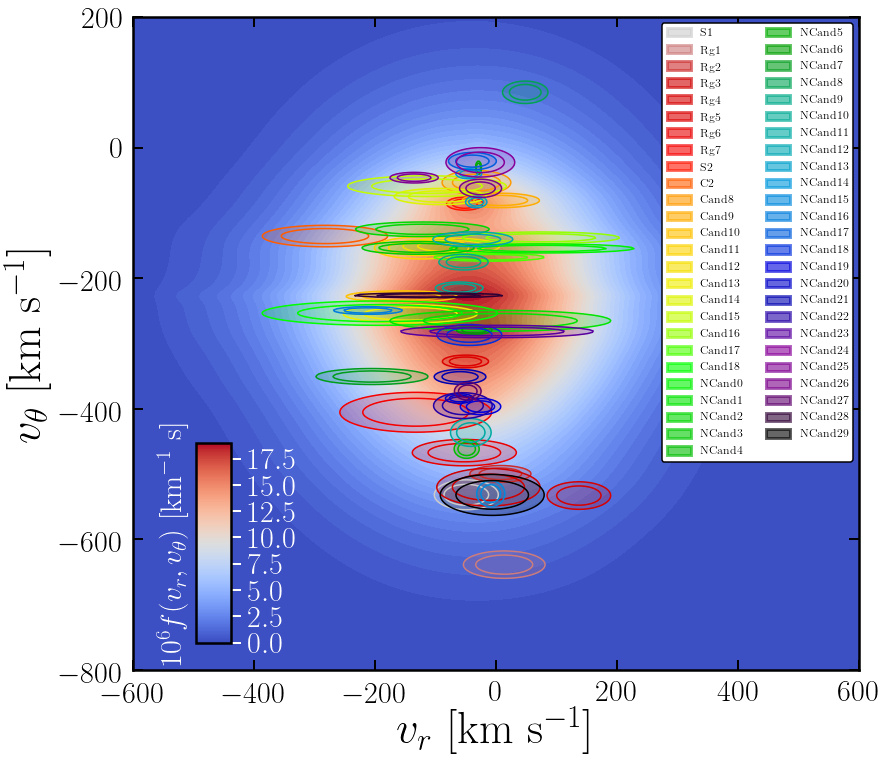

In [23]:
fig = plt.figure(figsize=(13,12))
ax = fig.add_subplot(111)
pltname = 'Shards_fv2'        
       
xi_aniso = 0.6
xi_iso = 1.0-xi_aniso
fv2_total = xi_iso*fv2_Iso + (xi_aniso/2.0)*(fv2_Saus+sum(fv2_Shards,2))
plt.contourf(vr,vth,transpose(fv2_total)*1e6,50,cmap=cm.coolwarm)

for i in range(0,nshards):
    f2 = transpose(fv2_Shards[:,:,i])
    plt.contourf(vr,vth,f2,levels=[amax(f2)*0.9,amax(f2)*0.95,amax(f2)],alpha=0.2,colors=((colstrs[i,:]),),linewidth=3)
    plt.contour(vr,vth,f2,levels=[amax(f2)*0.9,amax(f2)*0.95,amax(f2)],colors=((colstrs[i,:]),),linewidth=3)
    plt.fill_between([-10000,-10000],[0,1],linewidth=3,alpha=0.6,color=colstrs[i,:],label=names[i])
leg = plt.legend(loc='upper right',fontsize=12,edgecolor='k',framealpha=1.0,ncol=2)
leg.get_frame().set_linewidth(1.5)

vmin = amin(fv2_total)*1e6
vmax = amax(fv2_total)*1e6

# Plot fiddling
plt.xlim([-600,600])
plt.ylim([-800,200])
ax.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10,labelsize=30)
ax.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
plt.xlabel(r"$v_r$ [km s$^{-1}$]",fontsize=45);
plt.ylabel(r"$v_\theta$ [km s$^{-1}$]",fontsize=45);

# Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-480, -60, 700, 400]) 
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes)
f = plt.gcf().get_children()
cbar = f[2]
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)
cbar.set_ylabel(r'$10^6 f(v_r,v_\theta)$ [km$^{-1}$ s]')
cbar.yaxis.label.set_size(30)
cbar.yaxis.set_label_position("left")
cbar.yaxis.label.set_color('w')
cbar.xaxis.label.set_color('w')
cbar.tick_params(axis='x', colors='w')
cbar.tick_params(axis='y', colors='w')
cbar.spines['bottom'].set_color('w')
cbar.spines['top'].set_color('w') 
cbar.spines['right'].set_color('w')
cbar.spines['left'].set_color('w')

# Save figure
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')



# Annual modulation
Plot range and amplitude of the annual modulation

In [24]:
# DM params
A = Xe131.MassNumber
m_chi = 20.0
sigma_p = 1.0e-45

# Energy range
n = 100
E_th = 0.0001
E_max = 50.0
E = linspace(E_th,E_max,n)
v_min = MinimumWIMPSpeed(E,A,m_chi)

# Loop over times
ndays = 50
days = linspace(0,365,ndays)
dR0 = zeros(shape=(ndays,n))
dR = zeros(shape=(ndays,n))
R = zeros(shape=ndays)
R0 = zeros(shape=ndays)
for i in range(0,ndays):
    gmin0 = gvmin_Isotropic(v_min,days[i])
    gmin_sub = zeros(shape=shape(gmin0))
    for isub in range(0,nshards):
        v_s = velocities[isub,:]
        sig_s = dispersions[isub,:]
        gmin_sub += pops[isub]*gvmin_Triaxial(v_min,days[i],sig_s,v_shift=v_s)
        #gmin_sub += pops[isub]*gvmin_Isotropic(v_min,days[i],sig=sqrt(sum(sig_s**2.0))/6.0,v_shift=v_s)
    dR[i,:] = diffRecoilRate_SI(E,gmin_sub,A,sigma_p,m_chi,rho_0=0.55)
    dR0[i,:] = diffRecoilRate_SI(E,gmin0,A,sigma_p,m_chi,rho_0=0.55)
    R[i] = trapz(dR[i,(E>E_th)],E[E>E_th])
    R0[i] = trapz(dR0[i,(E>E_th)],E[E>E_th])
    print i
    
Rdiff = zeros(shape=n)
Rdiff0 = zeros(shape=n)
for i in range(0,n):
    Rdiff[i] = max(dR[:,i])-min(dR[:,i])
    Rdiff0[i] = max(dR0[:,i])-min(dR0[:,i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


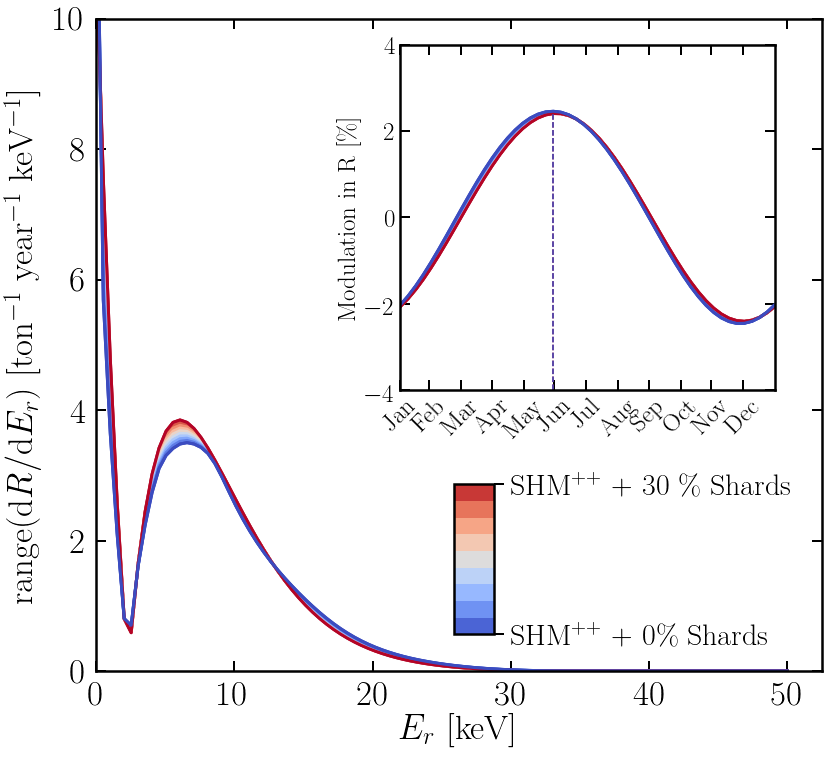

In [25]:
# Figure
pltname = 'Shards_annualmod'
fig = plt.figure(figsize=(13,12))
ax1 = fig.add_subplot(111)
left, bottom, width, height = [0.45, 0.45, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])

col = flipud(cm.coolwarm(linspace(0,1,n_xi)))

# Main plot
plt.sca(ax1)
y2 = xi_vals[-1]*Rdiff+(1-xi_vals[-1])*Rdiff0
for i in range(0,n_xi):
    plt.fill_between(E,xi_vals[i]*Rdiff+(1-xi_vals[i])*Rdiff0,y2=y2,color=col[i,:],alpha=0.5)
    plt.plot(E,xi_vals[i]*Rdiff+(1-xi_vals[i])*Rdiff0,'-',color=col[i,:],linewidth=3)
plt.plot(E,Rdiff0,label=cbar_max,linewidth=3,color=col[0,:])
plt.plot(E,y2,label=cbar_min,linewidth=3,color=col[-1,:])
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xlabel(r"$E_r$ [keV]",fontsize=35);
plt.ylabel(r"range($\textrm{d}R/\textrm{d}E_r$) [ton$^{-1}$ year$^{-1}$ keV$^{-1}$]" ,fontsize=35,labelpad=10);
ax1.set_xlim(left=0.0)
ax1.set_ylim(bottom=0.0,top=10.0)
ax1.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10)
ax1.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)

# Inset plot
plt.sca(ax2)
R0mid = (max(R0)+min(R0))/2.0
Rmid = (max(R)+min(R))/2.0
y2 = 100*xi_vals[-1]*(R-Rmid)/Rmid+100*(1.0-xi_vals[-1])*(R0-R0mid)/R0mid
for i in range(0,n_xi):
    dR = 100*xi_vals[i]*(R-Rmid)/Rmid+100*(1.0-xi_vals[i])*(R0-R0mid)/R0mid
    plt.fill_between(days,dR,y2=y2,color=col[i,:],alpha=0.5)
    plt.plot(days,dR,'-',color=col[i,:],linewidth=3)
plt.plot(days,100*(R0-R0mid)/R0mid,linewidth=3,color=col[0,:])
plt.plot(days,y2,linewidth=3,color=col[-1,:])
dR = 100*(R0-R0mid)/R0mid
plt.plot([days[argmax(dR)],days[argmax(dR)]],[-4.0,amax(dR)],'--',color=col[0,:])
plt.plot([days[argmax(y2)],days[argmax(y2)]],[-4.0,amax(y2)],'--',color=col[-1,:])

plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
ax2.set_xlim(left=0.0,right=365)
ax2.set_ylim(bottom=-4.0,top=4.0)
plt.xticks(cumsum([31,28,31,30,31,30,31,31,30,31,30,31])-31,
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], 
           rotation=45)
plt.ylabel(r"Modulation in R [\%]" ,fontsize=25);
ax2.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=5,labelsize=25)

# Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax2, width="20%", height="30%", bbox_to_anchor=[320, -200, 200, 500]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi),orientation='vertical')
f = plt.gcf().get_children()
cbar = f[3]
cbar.set_yticklabels([cbar_min,cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)


plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

# Axion spectrum

In [27]:
import warnings
warnings.filterwarnings("ignore")

c_km = 3e8/1000

# Axion mass
m_a = 3e-6
m_a_s = m_a/6.58e-16

# Converting frequency to speed
n = 100
vmin = 0.1
vmax = 800
omega_min = (m_a_s)*(1+(vmin/c_km)**2.0/2.0)
omega_max = (m_a_s)*(1+(vmax/c_km)**2.0/2.0)
axionBW = (omega_max-omega_min)
omega = linspace(omega_min-0.21*axionBW,omega_max+0.21*axionBW,n)
omega_min = omega[0]
omega_max = omega[-1]
domega = omega[1]-omega[0]
v = c_km*sqrt(2*(omega-m_a_s)/omega)
v[omega<=m_a_s] = 0.0
dv = (1.0/m_a_s)*(c_km/v)*c_km
dv[omega<=m_a_s] = 0.0

# Plot power spectra
fv_Iso = SpeedDist_Isotropic(v,day)
fv_Saus = SpeedDist_Triaxial(v,day,sig_beta)
fv0 = (1-0.25)*fv_Iso + 0.25*fv_Saus
fv = zeros(shape=(nshards,n))
for i in range(0,nshards):
    v_s = velocities[i,:]
    sig_s = dispersions[i,:]
    fvsub = pops[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s)
    fv[i,:] = fvsub
    print '{:3d}{:9s}{:7s}{:7.2f}{:7.2f}{:7.2f}{:14s}{:7.2f}{:7.2f}{:7.2f}{:10s}{:3d}'.format(i+1,': '+names[i],'V_str = ',v_s[0],v_s[1],v_s[2],' |  sig_str = ',sig_s[0],sig_s[1],sig_s[2],' |  pop = ',int(pops[i]*sum(dat[:,9])))


  1: S1     V_str =   -8.60-286.70 -67.90 |  sig_str =  115.30  49.90  60.00 |  pop =  34
  2: Rg1    V_str =   54.10-393.80  68.30 |  sig_str =  147.20  45.70 149.40 |  pop =  20
  3: Rg2    V_str =   47.80-254.60  71.80 |  sig_str =  110.20  27.80 172.10 |  pop =  20
  4: Rg3    V_str =   28.00-275.10  18.00 |  sig_str =  186.00  62.70 136.50 |  pop =  16
  5: Rg4    V_str =  177.60-287.90 117.90 |  sig_str =  114.60  46.00 162.70 |  pop =  13
  6: Rg5    V_str =  -10.00 -82.30  -0.60 |  sig_str =   83.20  21.20 162.70 |  pop =  29
  7: Rg6    V_str =  -11.90-222.10  88.00 |  sig_str =  187.60  44.00 134.90 |  pop =  30
  8: Rg7    V_str =  -92.30-160.20 -33.40 |  sig_str =  274.60  66.50 178.10 |  pop =  14
  9: S2     V_str =  -11.20 159.60-166.50 |  sig_str =   65.60  21.90 151.70 |  pop =  73
 10: C2     V_str = -242.40 109.90 180.70 |  sig_str =  229.20  35.90 236.10 |  pop =  22
 11: Cand8  V_str =    8.20 192.00 -25.00 |  sig_str =  124.00  40.20 186.60 |  pop =  49
 12: Cand9

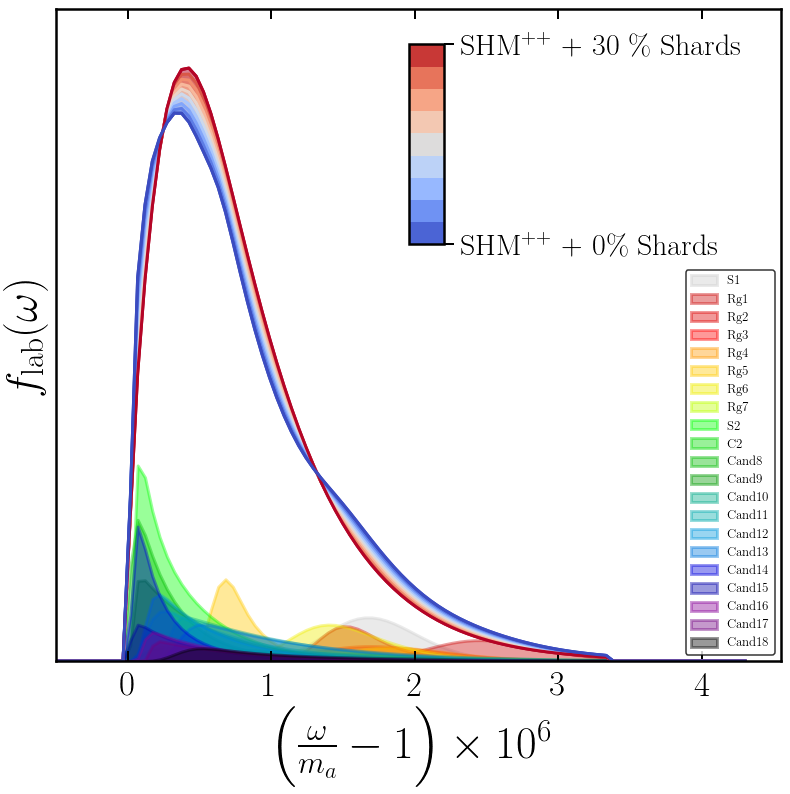

In [28]:
# Figure setup
fig = plt.figure(figsize=(13,12))
ax = fig.add_subplot(111)
pltname = 'Shards_axionspectrum'

x = 1e6*(omega/m_a_s-1)
ys = domega*dv

y2 = ys*(xi_vals[-1]*sum(fv,0)+(1.0-xi_vals[-1])*fv0)
for i in range(0,n_xi):
    plt.fill_between(x,ys*(xi_vals[i]*sum(fv,0)+(1.0-xi_vals[i])*fv0),y2=y2,color=col[i,:],alpha=0.5)
    plt.plot(x,ys*(xi_vals[i]*sum(fv,0)+(1.0-xi_vals[i])*fv0),'-',color=col[i,:],linewidth=3)
    
plt.plot(x,ys*fv0,'-',color=col[0,:],linewidth=3)
plt.plot(x,y2,'-',color=col[-1,:],linewidth=3)

# Plot individual streams
colstrs = flipud(cm.spectral(linspace(0,1,nshards)))
for i in range(0,nshards):
    plt.fill_between(x,ys*fv[i,:],linewidth=3,alpha=0.4,color=colstrs[i,:],label = names[i])
    
ax.set_xlim(left=-0.5)
ax.set_ylim(bottom=0.0,top=amax(fv0*ys)*1.1)
ax.tick_params(which='major',direction='in',width=2,length=10,left=False,top=True,pad=10,labelleft=False)
plt.xticks(fontsize=35)
plt.xlabel(r"$\left(\frac{\omega}{m_a} -1\right)\times 10^6$",fontsize=45);
plt.ylabel(r"$f_{\rm lab}(\omega)$",fontsize=45);
leg = plt.legend(loc='lower right',fontsize=13,edgecolor='k')
leg.get_frame().set_linewidth(1.5)

# Custom colorbar
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-190, 330, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([cbar_min,cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)

# Save figure
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

# Directional signal

In [3]:
import warnings
warnings.filterwarnings("ignore", module="mpl_toolkits.basemap")
from mpl_toolkits.basemap import Basemap
fig = plt.figure(figsize=(12,10))
pltname = 'Shards_Directional'

n = 200
ph = linspace(-pi, pi-2*pi/n, n)
th = linspace(0,pi, n/2)
PH,TH = meshgrid(ph,th)
X = cos(PH)*sin(TH)
Y = -sin(PH)*sin(TH)
Z = cos(TH)
ii = 0
q = zeros(shape=(n*n/2,3))
for i in range(0,n/2):
    for j in range(0,n):
        q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
        ii = ii+1

# Benchmark
ne = 100
nbins = 3
E = zeros(shape=(nbins,ne))
E[0,:] = linspace(1.0,5.0,ne)
E[1,:] = linspace(5.0,10.0,ne)
E[2,:] = linspace(10.0,20.0,ne)

m_chi = 100.0
sigma_p = 1.0e-45
A = F19.MassNumber

# Radon transform and rate
dR0 = zeros(shape=(3,n*n/2))
dR = zeros(shape=(3,n*n/2))
fhat0 = zeros(shape=(n*n/2))
for ibin in range(0,nbins):
    E_r = E[ibin,:]
    v_min = MinimumWIMPSpeed(E_r,A,m_chi)
    for ie in range(0,ne):
        fhat0 = fhat_Isotropic(v_min[ie],-1.0*q,day)
        dR0[ibin,:] += diffRecoilRate_SI(E_r[ie],fhat0,A,sigma_p,m_chi)

        fhat = zeros(shape=(n*n/2))
        for i in range(0,nshards):
            v_s = velocities[i,:]
            sig_s = dispersions[i,:]
            fhat += pops[i]*fhat_Triaxial(v_min[ie],-1.0*q,day,sig_s,v_shift=v_s)
        dR[ibin,:] += diffRecoilRate_SI(E_r[ie],fhat,A,sigma_p,m_chi)
    print 'bin =',ibin

    

# Convert list into Mollweide map
dR_map0 = zeros(shape=(n/2,n,3))
dR_map = zeros(shape=(n/2,n,3))
for ibin in range(0,3):
    ii = 0
    for i in range(0,n/2):
        for j in range(0,n):
            dR_map0[i,j,ibin] = dR0[ibin,ii]
            dR_map[i,j,ibin] = dR[ibin,ii]
            ii = ii+1
    dR_map0[:,:,ibin] = flipud(dR_map0[:,:,ibin])     
    dR_map[:,:,ibin] = flipud(dR_map[:,:,ibin])        

bin = 0
bin = 1
bin = 2


may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).WARNING: x coordinate not montonically increasing - contour plot
may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).WARNING: x coordinate not montonically increasing - contour plot
may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see

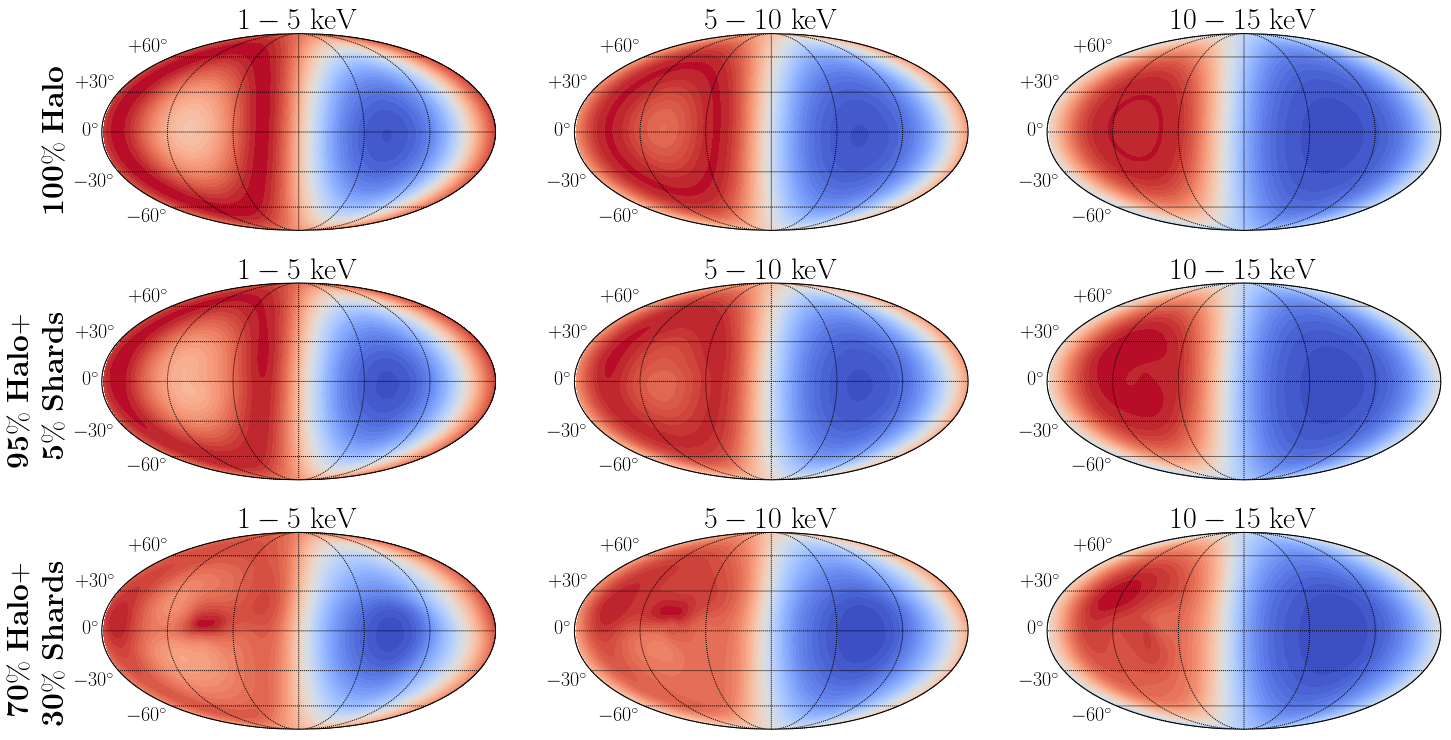

In [4]:
fig, axarr = plt.subplots(3, 3,figsize=(24,13))
warnings.filterwarnings("ignore")

tit = [r'$1 - 5$ keV',r'$5-10$ keV',r'$10-15$ keV']
for ibin in range(0,3): 
    plt.sca(axarr[0,ibin])
    m = Basemap(projection='moll',lon_0=180.0,resolution='c',celestial=True)
    #for i in range(0,4): # loop is to cure some rendering issues with matplotlib
    m.contourf(PH*180/pi, TH*180/pi-90.0, dR_map0[:,:,ibin],50, cmap=cmap,latlon=True)
    m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
    m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
    plt.title(tit[ibin],fontsize=30)

for ibin in range(0,3): 
    plt.sca(axarr[1,ibin])
    m = Basemap(projection='moll',lon_0=180.0,resolution='c',celestial=True)
    #for i in range(0,4): # loop is to cure some rendering issues with matplotlib
    m.contourf(PH*180/pi, TH*180/pi-90.0, 0.95*dR_map0[:,:,ibin]+0.05*dR_map[:,:,ibin],50, cmap=cmap,latlon=True)
    m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
    m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
    plt.title(tit[ibin],fontsize=30)

for ibin in range(0,3): 
    plt.sca(axarr[2,ibin])
    m = Basemap(projection='moll',lon_0=180.0,resolution='c',celestial=True)
    #for i in range(0,4): # loop is to cure some rendering issues with matplotlib
    m.contourf(PH*180/pi, TH*180/pi-90.0, 0.7*dR_map0[:,:,ibin]+0.3*dR_map[:,:,ibin],50, cmap=cmap,latlon=True)
    m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
    m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
    plt.title(tit[ibin],fontsize=30)

plt.sca(axarr[0,0])
plt.annotate(r'{\bf 100}\% {\bf Halo}', xy=(-0.15, 0.75), xycoords='axes fraction',fontsize=30,rotation=90)

plt.sca(axarr[1,0])
plt.annotate(r'{\bf 95}\% {\bf Halo}+', xy=(-0.24, 0.75), xycoords='axes fraction',fontsize=30,rotation=90)
plt.annotate(r'{\bf 5}\% {\bf Shards}', xy=(-0.15, 0.75), xycoords='axes fraction',fontsize=30,rotation=90)

plt.sca(axarr[2,0])
plt.annotate(r'{\bf 70}\% {\bf Halo}+', xy=(-0.24, 0.75), xycoords='axes fraction',fontsize=30,rotation=90)
plt.annotate(r'{\bf 30}\% {\bf Shards}', xy=(-0.15, 0.75), xycoords='axes fraction',fontsize=30,rotation=90)

#plt.tight_layout()
# colorbar
#cbar = plt.colorbar(orientation='horizontal',pad=0.02)
#cbar.ax.tick_params(labelsize=20,pad=10)
#cbar.set_label(r'$\frac{{\rm d}^2 R}{{\rm d}E_r {\rm d}\Omega_r}$ [ton$^{-1}$ year$^{-1}$ keV$^{-1}$ sr$^{-1}$]',fontsize=35,labelpad=10)
plt.show()

# save figure
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

In [137]:
from scipy.optimize import fmin

def qhat(x):
    qhat = zeros(shape=(1,3))
    qhat[0,0] = sqrt(1-x[0]**2.0)*cos(x[1])
    qhat[0,1] = sqrt(1-x[0]**2.0)*sin(x[1])
    qhat[0,2] = x[0]
    return qhat

v_lab = LabVelocitySimple(day)
x_lab = -1.0*v_lab/sqrt(sum(v_lab**2.0))

m_chi = 50.0
sigma_p = 1.0e-45
A = F19.MassNumber

ne = 300
Evals = linspace(0.1,100.0,ne)
xmin0 = zeros(shape=(ne,2))
xmin_in = array([-0.05,4.4])
dth0 = zeros(shape=(ne))
for i in range(0,ne):
    v_min = MinimumWIMPSpeed(Evals[i],A,m_chi)
    def fhat0(x):
        return -1.0*fhat_Isotropic(v_min,qhat(x),day)
    if fhat0(xmin_in)==0.0:
        dth0[i] = 0.0
    else:
        res = fmin(fhat0,xmin_in,disp=False)
        xmin0[i,0] = res[0]
        xmin0[i,1] = res[1]
        xmin_in = xmin0[i,:]
        dth0[i] = 180/pi*arccos(sum(qhat(xmin_in)*x_lab))

xmin = zeros(shape=(ne,2,n_xi))
dth = zeros(shape=(ne,n_xi))
for j in range(0,n_xi):
    xi = xi_vals[j]
    for i in range(0,ne):
        v_min = MinimumWIMPSpeed(Evals[i],A,m_chi)
        def fhat(x):
            fhat = -1.0*(1-xi)*fhat_Isotropic(v_min,qhat(x),day)
            for k in range(0,nshards):
                v_s = velocities[k,:]
                sig_s = dispersions[k,:]
                fhat += -1.0*xi*pops[k]*fhat_Triaxial(v_min,qhat(x),day,sig_s,v_shift=v_s)
            return fhat
        if fhat(xmin_in)==0.0:
            dth[i,j] = 0.0
        else:
            res = fmin(fhat,xmin_in,disp=False)
            xmin[i,0,j] = res[0]
            xmin[i,1,j] = res[1]
            xmin_in = xmin[i,:,j]
            dth[i,j] = 180/pi*arccos(sum(qhat(xmin_in)*x_lab))

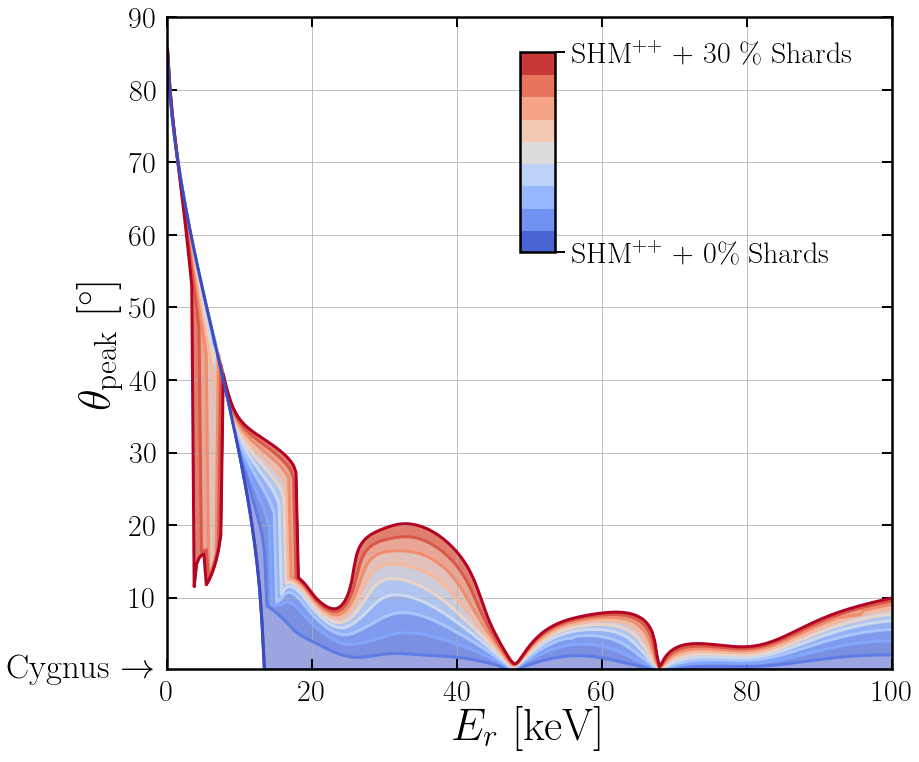

In [138]:
# Figure setup
from random import gauss
fig = plt.figure(figsize=(13,12))
ax = fig.add_subplot(111)
pltname = 'Shards_peakdirection'

col = (cm.coolwarm(linspace(0,1,n_xi)))
cmap = cm.coolwarm
for j in range(0,n_xi):
    plt.fill_between(Evals,dth[:,j],y2=dth[:,-1],color=col[j,:],alpha=0.5)
    plt.plot(Evals,dth[:,j],color=col[j,:],linewidth=3)

plt.plot(Evals,dth0,linewidth=3,color=col[0,:])
plt.ylim([0.1,90])
plt.xlim([0,amax(Evals)])
ax.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10,labelsize=30)
ax.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
plt.ylabel(r"$\theta_{\rm peak}$ [$^\circ$]",fontsize=45);
plt.xlabel(r"$E_r$ [keV]",fontsize=45);
plt.text(-22,-1,r'Cygnus $\rightarrow$',fontsize=35)
plt.grid()

# Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-190, 330, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([cbar_min, cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)


# Save figure
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

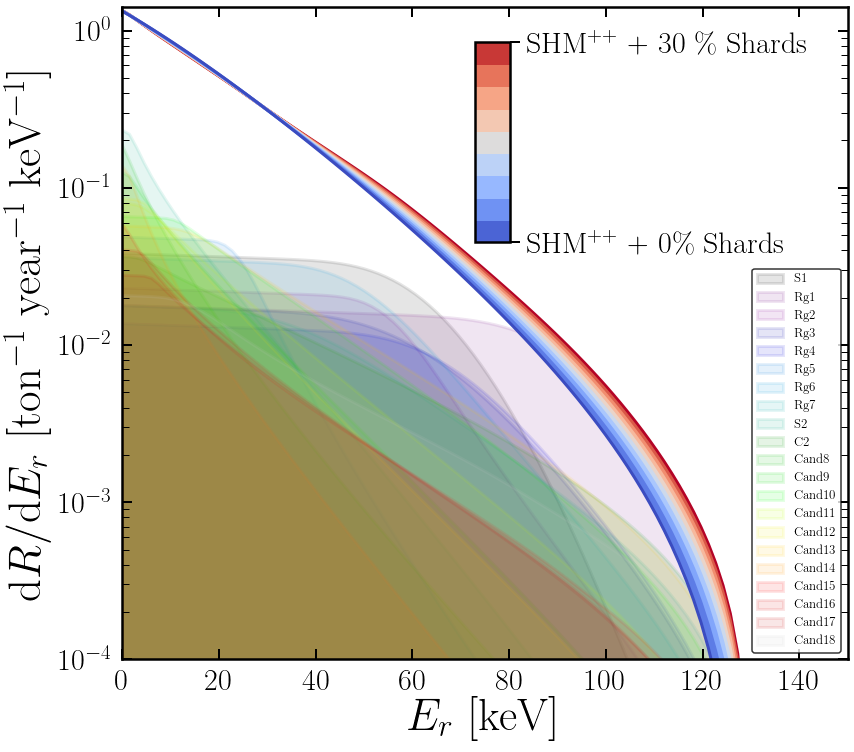

In [136]:
# Figure setup
fig = plt.figure(figsize=(13,12))
ax = fig.add_subplot(111)
pltname = 'Shards_dRdE'

ne = 100
Evals = linspace(0.001,150.0,ne)

A = 19
m_chi = 50.0
sigma_p = 1.e-45

v_min = MinimumWIMPSpeed(Evals,A,m_chi)

# Halo
gmin0 = 1.0*gvmin_Isotropic(v_min,day)
#gmin0 += 0.25*gvmin_Triaxial(v_min,v_lab)
dR0 = diffRecoilRate_SI(Evals,gmin0,A,sigma_p,m_chi,rho_0=0.55)

# Streams
dR = zeros(shape=(nshards,ne))
for isub in range(0,nshards):
    v_s = velocities[isub,:]
    sig_s = dispersions[isub,:]
    gmin_sub = pops[isub]*gvmin_Triaxial(v_min,day,sig_s,v_shift=v_s)
    dR[isub,:] =diffRecoilRate_SI(Evals,gmin_sub,A,sigma_p,m_chi,rho_0=0.55)

# Plot individual streams
colstrs = (cm.spectral(linspace(0,1,nshards)))
for i in range(0,nshards):
    plt.fill_between(Evals,dR[i,:],linewidth=3,color=colstrs[i,:],label = names[i],alpha=0.1)
leg = plt.legend(loc='lower right',fontsize=13,edgecolor='k')
leg.get_frame().set_linewidth(1.5)   

# Plot combined model
for j in range(0,n_xi):
    y = (1-xi_vals[n_xi-1-j])*dR0+xi_vals[n_xi-1-j]*sum(dR,0)
    plt.fill_between(Evals,y,y2=dR0,color=col[n_xi-1-j,:])
    plt.plot(Evals,y,color=col[n_xi-1-j,:],linewidth=3)


# Style
ax.set_xlim(left=0.0,right=Evals[-1])
ax.set_ylim(bottom=1.0e-4)
plt.yscale('log')
ax.tick_params(which='major',direction='in',width=2,length=10,right=True,top=True,pad=10,labelsize=30)
ax.tick_params(which='minor',direction='in',width=1,length=7,right=True,top=True)
plt.ylabel(r'$\textrm{d}R/\textrm{d}E_r$ [ton$^{-1}$ year$^{-1}$ keV$^{-1}$]',fontsize=45);
plt.xlabel(r"$E_r$ [keV]",fontsize=45);


# Custom colorbar
cbaxes = inset_axes(ax, width="5%", height="50%", bbox_to_anchor=[-190, 330, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cbaxes,ticks=(0,1),boundaries=linspace(0,1,n_xi))
f = plt.gcf().get_children()
cbar = f[2]
cbar.set_yticklabels([cbar_min,cbar_max])  # vertically oriented colorbar
cbar.tick_params(labelsize=30) 
cbar.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7)
cbar.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False)

# Save figure
plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

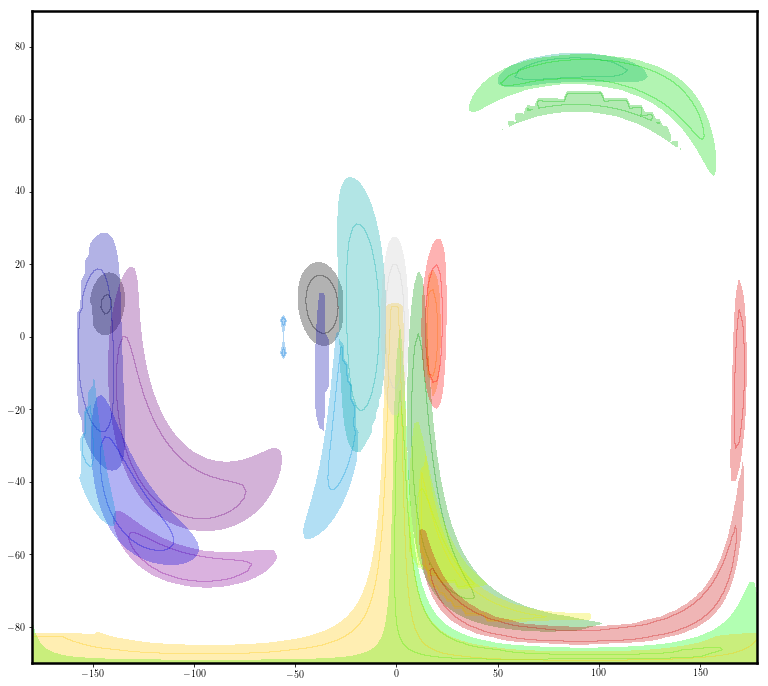

In [129]:
# Figure setup
from mpl_toolkits.basemap import shiftgrid
from IPython.display import clear_output

fig = plt.figure(figsize=(13,12))
ax = fig.add_subplot(111)
pltname = 'ShardsVelocityDist_Mollweide'

v_lab = array([0.0,0.0,0.0])

n = 200
ph = flipud(linspace(-pi, pi-2*pi/n, n))
th = linspace(0,pi, n/2)
PH,TH = meshgrid(ph,th)
X = cos(PH)*sin(TH)
Y = -sin(PH)*sin(TH)
Z = cos(TH)
ii = 0
q = zeros(shape=(n*n/2,3))
for i in range(0,n/2):
    for j in range(0,n):
        q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
        ii = ii+1

m = Basemap(projection='moll',lon_0=0.0,resolution='c',celestial=True)
fv3D = zeros(shape=n*n/2)
nv = 1000
v_vals = linspace(0.1,600,nv)
for isub in range(0,nshards):
    v_str = velocities[isub,:]
    #v_str = array([200,-400,50])
    x_str = v_str/sqrt(sum(v_str**2.0))
    v_s = v_str+LabVelocitySimple(day)
    #v_s = array([0.0,300.0,0.0])+LabVelocitySimple(day)
    sig_s = dispersions[isub,:]
    #sig_s = array([100.0,100.0,100.0])
    for j in range(0,nv):
        mask = arccos(q[:,0]*x_str[0]+q[:,1]*x_str[1]+q[:,2]*x_str[2])>0
        fv3D = pops[isub]*VelocityDist_Triaxial(-v_vals[j]*q,day,sig_s,v_shift=v_s)
    
    # Convert list into Mollweide map
    fv_map = zeros(shape=(n/2,n))
    ii = 0
    for i in range(0,n/2):
        for j in range(0,n):
            fv_map[i,j] = fv3D[ii]
            ii = ii+1
    fv_map = flipud(fv_map)
    #fv_map[:,:] = flipud(fv_map[:,:])     
    #fv_map,lonsout = shiftgrid(0.0,fv_map,th*180/pi-90.0)
    m.contourf(PH*180/pi, TH*180/pi-90.0,fv_map,
              levels=[amax(fv_map)*0.25,amax(fv_map)*0.5,amax(fv_map)],
              colors=((colstrs[isub,:]),),latlon=True,alpha=0.3)
    clear_output()

m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians

plt.show()
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')